In [4]:

suppressWarnings(library(grf, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(quantregForest, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(fields, quietly = TRUE, warn.conflicts = FALSE))


### In this module you will learn how to:

1. Build a random forest for conditional average treatment effects
2. Make quantile predictions from quantile forests

## The Data

In this module we will see how to build a random forest for conditional average treatment effects (CATE) or conditional average treatment effects on the treated (CATT).

Once again we will simulate our own data for this section. In this case we will be using a slight modification of the example from the package documentation (https://github.com/swager/grf/tree/master/r-package/grf/R). The goal with this example will be to demonstrate why we need an "honest" estimation strategy and when CATT will be different from CATE.

The first example is the case where treatment is randomly assigned, but the effect of the treatment is a function of the first covariate. The data is generated by:

$x_j$ is uniform from $-1$ to $1$ for $j=\{1,2,\dots,10\}$
$Y = w\max\{x_1,0\} + x_2 + \min\{x_3,0\} +\varepsilon$

The treatment effect $w$ is generated from a bernoulli distribution with probability $0.5$ and the error term is i.i.d standard normal.

In [5]:
# Generate data.
set.seed(271828)
n = 2000; p = 10
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
# Perform treatment effect estimation.
W = rbinom(n, 1, 0.5)
Y = pmax(X[,1], 0) * W + X[,2] + pmin(X[,3], 0) + rnorm(n)

## Naive Estimation

A naive way of approaching this problem is to build the tree with the same sample from which we estimate the treatment effects. This is very similar to the double ML case. Instead of writing the code for this ourselves, we will take advantage of the causal_forest package in R. To see what happens when we ignore "honest" we can set this to false in the estimation package.

In [6]:
te.forest = causal_forest(X, Y, W,
                num.trees = 4000, honest=FALSE)
# grow and estimate the treatment effects w/ the same sample
print(te.forest)                                         
# Examine the forest that we grew based on variable importance 

GRF forest object of type causal_forest 
Number of trees:  4000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.737 0.021 0.058 0.021 0.032 0.026 0.042 0.010 0.025 0.026 


## Naive Evaluation

The forest estimation gives us variable importance based on splitting. As we should expect, the most important variable is $x_1$, although we are picking up more noise than would be ideal here. We know that $x_4,x_5,\dots,x_
{10}$ aren't actually involved in the model at all, but the forest picks them up about the same amount of time as $x_2$ and $x_3$

How did we do in terms of treatment effect estimation?

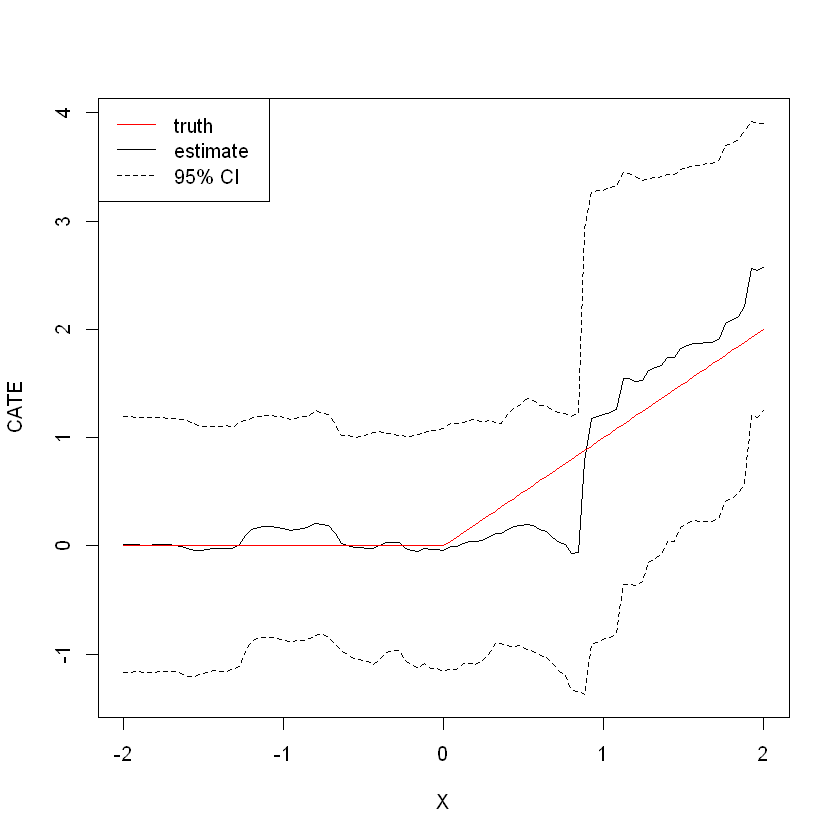

In [7]:
te.hat = predict(te.forest, X.test, estimate.variance = TRUE)           
# predict CATE for range of x1

sigma.hat = sqrt(te.hat$variance.estimates)
plot(X.test[,1], te.hat$predictions, 
     ylim = range(te.hat$predictions + 1.96 * sigma.hat,
                  te.hat$predictions - 1.96 * sigma.hat, 0, 2),
                  xlab = "X", ylab = "CATE", type = "l")

lines(X.test[,1], te.hat$predictions + 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], te.hat$predictions - 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 1)
legend("topleft",c('truth','estimate','95% CI'),lty=c(1,1,2),
       col=c('red','black','black'))

In this example the estimate is not too bad, but we don't do a good job capturing the changepoint. Let's see what happens when we use the "honest" method. Let's build the tree and estimate the treatment effects with different subsamples.

## Honest Estimation

Switching to honest is very easy, we simply use the same function but leave the default settings alone (honest=TRUE). To be consistent we will grow the same number of trees as we did before.

In [8]:
te.forest = causal_forest(X, Y, W,
                num.trees = 4000)
# grow and estimate the treatment effects w/ sample split
print(te.forest)
# Examine the forest that we grew based on variable importance 

GRF forest object of type causal_forest 
Number of trees:  4000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.695 0.029 0.049 0.030 0.036 0.036 0.039 0.023 0.030 0.033 


It is important to notice that we didn't solve the noise issue by using honesty. The variable importance is the same as before. However, we should have solved the inability to capture the changepoint and some of the bias in the treatment effect.

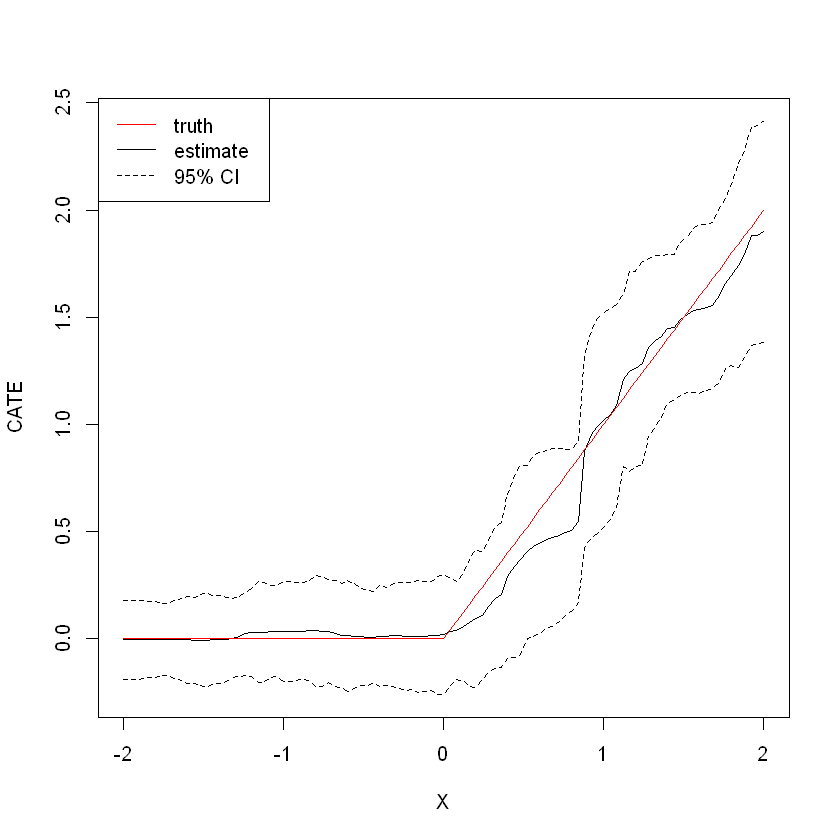

In [9]:
te.forest = causal_forest(X, Y, W, num.trees = 4000)
# grow and estimate the treatment effects w/ the diff samples
te.hat = predict(te.forest, X.test, estimate.variance = TRUE)
# predict CATE for range of x1

sigma.hat = sqrt(te.hat$variance.estimates)
plot(X.test[,1], te.hat$predictions, ylim = range(
            te.hat$predictions + 1.96 * sigma.hat, 
            te.hat$predictions - 1.96 * sigma.hat, 0, 2), 
            xlab = "X", ylab = "CATE", type = "l")

lines(X.test[,1], te.hat$predictions + 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], te.hat$predictions - 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 1)
legend("topleft",c('truth','estimate','95% CI'),lty=c(1,1,2),
       col=c('red','black','black'))

## Honest Evaluation

We pick up the changepoint much better here. You can also see how much tighter the confidence bands are in this case. In this example there isn't much of a difference between CATT and CATE as the treatment is randomly assigned.

In [12]:
# Estimate the conditional average treatment effect on the full sample (CATE).
print('CATE:')
average_treatment_effect(te.forest, target.sample = "all")
# Estimate the conditional average treatment effect on the treated sample (CATT).
print('CATT:')
average_treatment_effect(te.forest, target.sample = "treated")


[1] "CATE:"


estimate    std.err 
0.37783685 0.04616973

[1] "CATT:"


estimate    std.err 
0.37730215 0.04623133

## What about a Selection Equation?

We can make the probability of treatment be a function of an observable. When we do this we are no longer assuming that treatment is randomly assigned. Remember that this is not a problem so long as we have a way of estimating the propensity score. In this case we will assume the selection equation is a function of the observables. Let the probability of treatment be a function of $x_2$. The data generating process is:

$Y = w\max\{x_1,0\} + x_2 + \min\{x_3,0\} +\varepsilon$

The treatment effect $w$ is generated from a bernoulli distribution with probability $1/(1+\exp\{-x_2\})$ and the error term is i.i.d standard normal.

In [14]:

# Generate data.
set.seed(271828)
n = 2000; p = 10
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
# Perform treatment effect estimation.
sel = 1/(1+exp(-X[,2]))
W = rbinom(n, 1, sel)
Y = pmax(X[,1], 0) * W + X[,2] + pmin(X[,3], 0) + rnorm(n)

In [15]:
te.forest = causal_forest(X, Y, W)          
# grow the forest
te.hat = predict(te.forest, X.test)       
# the estimates are based on a subsample not included to grow the forest

# Estimate the conditional average treatment effect on the full sample (CATE).
print('CATE:')
average_treatment_effect(te.forest, target.sample = "all")

# Estimate the conditional average treatment effect on the treated sample (CATT).
print('CATT:')
average_treatment_effect(te.forest, target.sample = "treated")

[1] "CATE:"


estimate    std.err 
0.40619284 0.05161697

[1] "CATT:"


estimate    std.err 
0.43595703 0.05702109

## CATE vs CATT

Once we have a selection equation, the CATE and CATT will be different. Why is this? Individuals who undergo treatment will be systematically different than those who do not. This is that selection bias that we adjust for! The difference here is not very large, but the CATT is slightly larger than CATE. 


## Quantile Forests

We previously saw what a quantile regression was. Instead of estimating the conditional mean, we estimated the conditional quantile of the outcome variable. In the example, we assumed that the conditional quantile was a linear function of the covariates. Does this have to be the case? It turns out that we can actually use random forests to estimate conditional quantiles!

Just to demonstrate how this works consider the very simple conditional heteroskedastic model:


Let $y = x_1\varepsilon$
$x_1$ and $\varepsilon$ are both standard normal


In [16]:
n = 2000; p = 20
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
Y = X[,1] * rnorm(n)

# Train a quantile forest.
q.forest = quantile_forest(X, Y, quantiles=c(0.1, 0.5, 0.9))

Now that we have quantile predictions for $\tau = \{0.1,0.5,0.9\}$ we can plot these

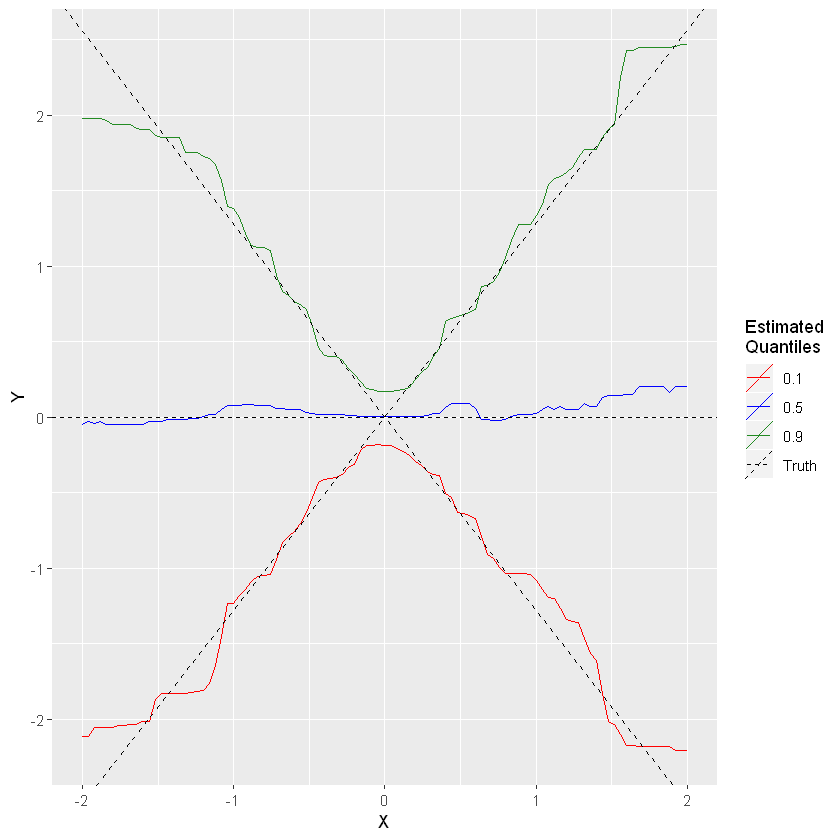

In [17]:
# Make predictions.
q.hat = predict(q.forest, X.test)
quantiles = data.frame(cbind(X.test[,1],q.hat))


ggplot(quantiles,aes(X.test[,1],q.hat[,1]))+
geom_line(aes(color='0.1')) + 
geom_line(aes(X.test[,1],q.hat[,2],color='0.5')) + 
geom_line(aes(X.test[,1],q.hat[,3],color='0.9')) +
geom_abline(aes(color='Truth',intercept = 0, slope = qnorm(0.9)), linetype = 'dashed') +
geom_abline(intercept = 0, slope = -qnorm(0.9), linetype = 'dashed') +
geom_abline(intercept = 0, slope = qnorm(0.5), linetype = 'dashed') +
labs(x = "X") +
labs(y = "Y") +
scale_colour_manual(
    name = "Estimated\nQuantiles", 
    values = c('0.1'="red",'0.5'="blue",'0.9'= "forestgreen",'Truth'='black'),
    guide = guide_legend(
    override.aes = list(linetype = c(1,1,1,2))))


## Visualizing the Quantiles

The predictions look pretty good in sample. There might be a bit of oversmoothing going on, there's a bit too much wiggle especially at larger values of $x$ for $\tau=0.5$. However, we didn't need a random forest to fit such a simple model.

## Out-of-Sample Accuracy

How accurate are our predictions for other quantiles? Let's check $\tau  = \{0.3,0.7\}$

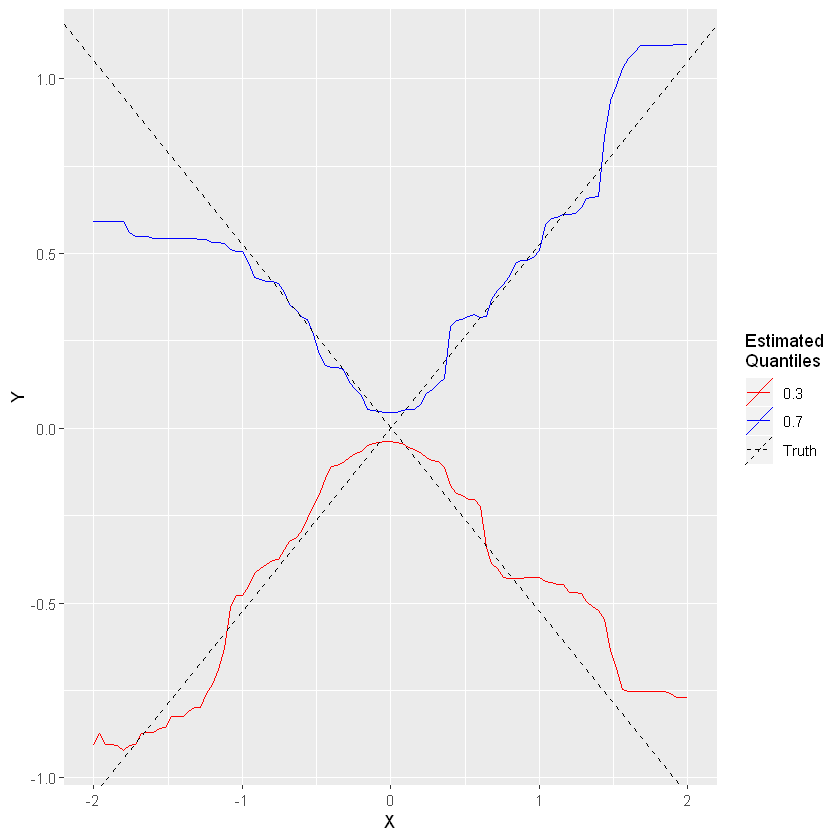

In [18]:
# Make predictions for different quantiles than those used in training.
q.hat = predict(q.forest, X.test, quantiles=c(0.3, 0.7))
quantiles = data.frame(cbind(X.test[,1],q.hat))

ggplot(quantiles,aes(X.test[,1],q.hat[,1]))+
geom_line(aes(color='0.3')) + 
geom_line(aes(X.test[,1],q.hat[,2],color='0.7')) + 
geom_abline(aes(color='Truth',intercept = 0, 
                slope = qnorm(0.7)), linetype = 'dashed') +
geom_abline(intercept = 0, slope = -qnorm(0.7), linetype = 'dashed') +
labs(x = "X") +
labs(y = "Y") +
scale_colour_manual(
    name = "Estimated\nQuantiles", 
    values = c('0.3'="red",'0.7'="blue",'Truth'='black'),
    guide = guide_legend(
    override.aes = list(linetype = c(1,1,2))))

That's impressive. We didn't train the model on these quantiles, but we are able to capture a lot of the variation without directly estimating them. In practice if we wanted to work with quantile forests we would probably have a much more complicated model in mind, but it's always good to make sure these methods work on the simplest examples first.

## Exercise: Module 7

In this module we introduced random forests for heterogeneous causal effects. This framework was similar to double ML as we employed sample splitting, but this model allowed for heterogeneity across the treatment effect. We also demonstrated how to implement quantile random forests on a very basic example. Let's look at a more exciting example of heterogeneous treatment effects. Consider an example where the treatment is randomly assigned, but the treatment effect depends on the sign of two covariates. The data is generated as follows:

$x_j$ is uniform from $-1$ to $1$ for $j=\{1,2,\dots,10\}$
$y = -1_{sign(x_1)=sign(x_2)}w + 1_{sign(x_1)\neq sign(x_2)}w+min\{x_3,0\}+\varepsilon$

The treatment effect $w$ is generated from a bernoulli distribution with probability $0.5$ and the error term is i.i.d standard normal.

1. Estimate the causal forest using honesty and 4000 trees
2. Predict the CATE over all possible values of $x_1$ and $x_2$
3. Does the causal forest pick up the heterogeneity in the treatment?

In [19]:
# Generate data.
set.seed(1234)
n = 2000
p = 10
X = matrix(runif(n*p,min=-1,max=1), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-1, 1, length.out = 101)
# Perform treatment effect estimation.
W = rbinom(n, 1, 0.5)
Y = W*(-(sign(X[,1])==sign(X[,2])) + (sign(X[,1])!=sign(X[,2]))) +
    pmin(X[,3], 0) + rnorm(n)

In [20]:
te.forest = causal_forest(X, Y, W, num.trees = 4000)         
# grow and estimate the treatment effects w/ the diff samples

In [21]:
total = 101
pb = txtProgressBar(min = 0, max = total, style = 3)
te.hat = matrix(0,nrow=101,ncol=101)
for (i in 1:101){
    Sys.sleep(0.1)
    xtmp = X.test
    X.test[,2] = xtmp[i,1]
    te.hat[,i] = predict(te.forest, X.test)$predictions   
    setTxtProgressBar(pb, i)
    # predict CATE for range of x1
}
close(pb)


  |======================================================================| 100%


Once we plot the CATE we see the forest picks up the discrete changes in the treatment effects very nicely!

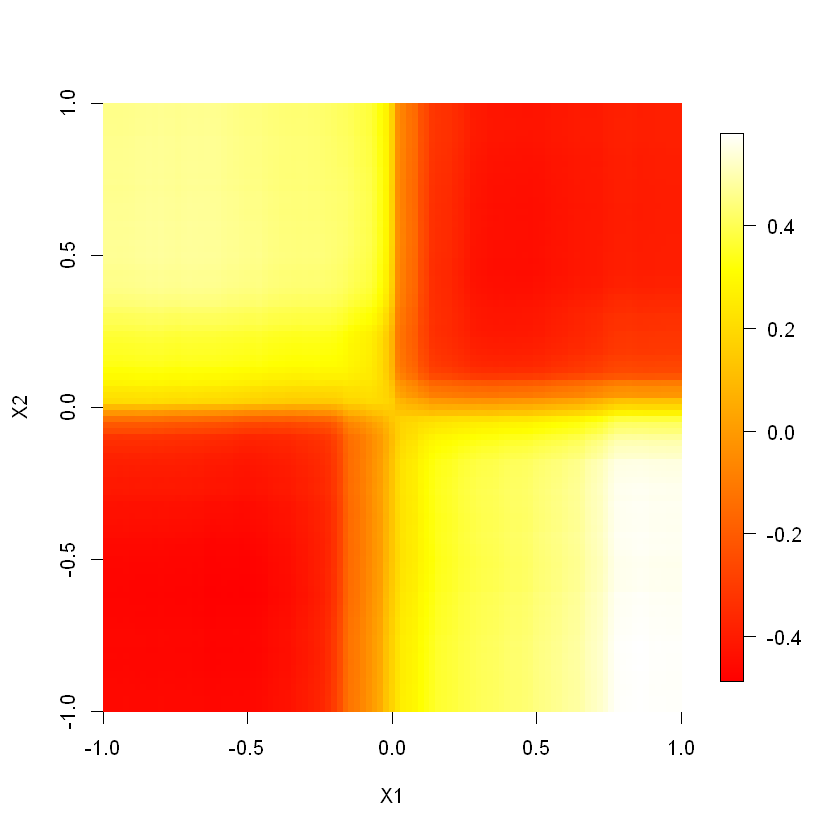

In [22]:
image.plot(X.test[,1],X.test[,1],
           te.hat,xlim=c(-1,1),
           ylim=c(-1,1),
           xlab = 'X1',
           ylab='X2',
           col=heat.colors(10000))